Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Loading and Combining Datasets ===
Combined dataset shape: (268, 11)

First few rows of combined data:
            State         Date   Frequency                 Unemployment_Rate  \
0          Region         Date   Frequency   Estimated Unemployment Rate (%)   
1  Andhra Pradesh   31-01-2020           M                              5.48   
2  Andhra Pradesh   29-02-2020           M                              5.83   
3  Andhra Pradesh   31-03-2020           M                              5.79   
4  Andhra Pradesh   30-04-2020           M                             20.51   

          Labour_Force                        Participation_Rate Area_Type  \
0   Estimated Employed   Estimated Labour Participation Rate (%)  Combined   
1             16635535                                     41.02  Combined   
2             16545652                           

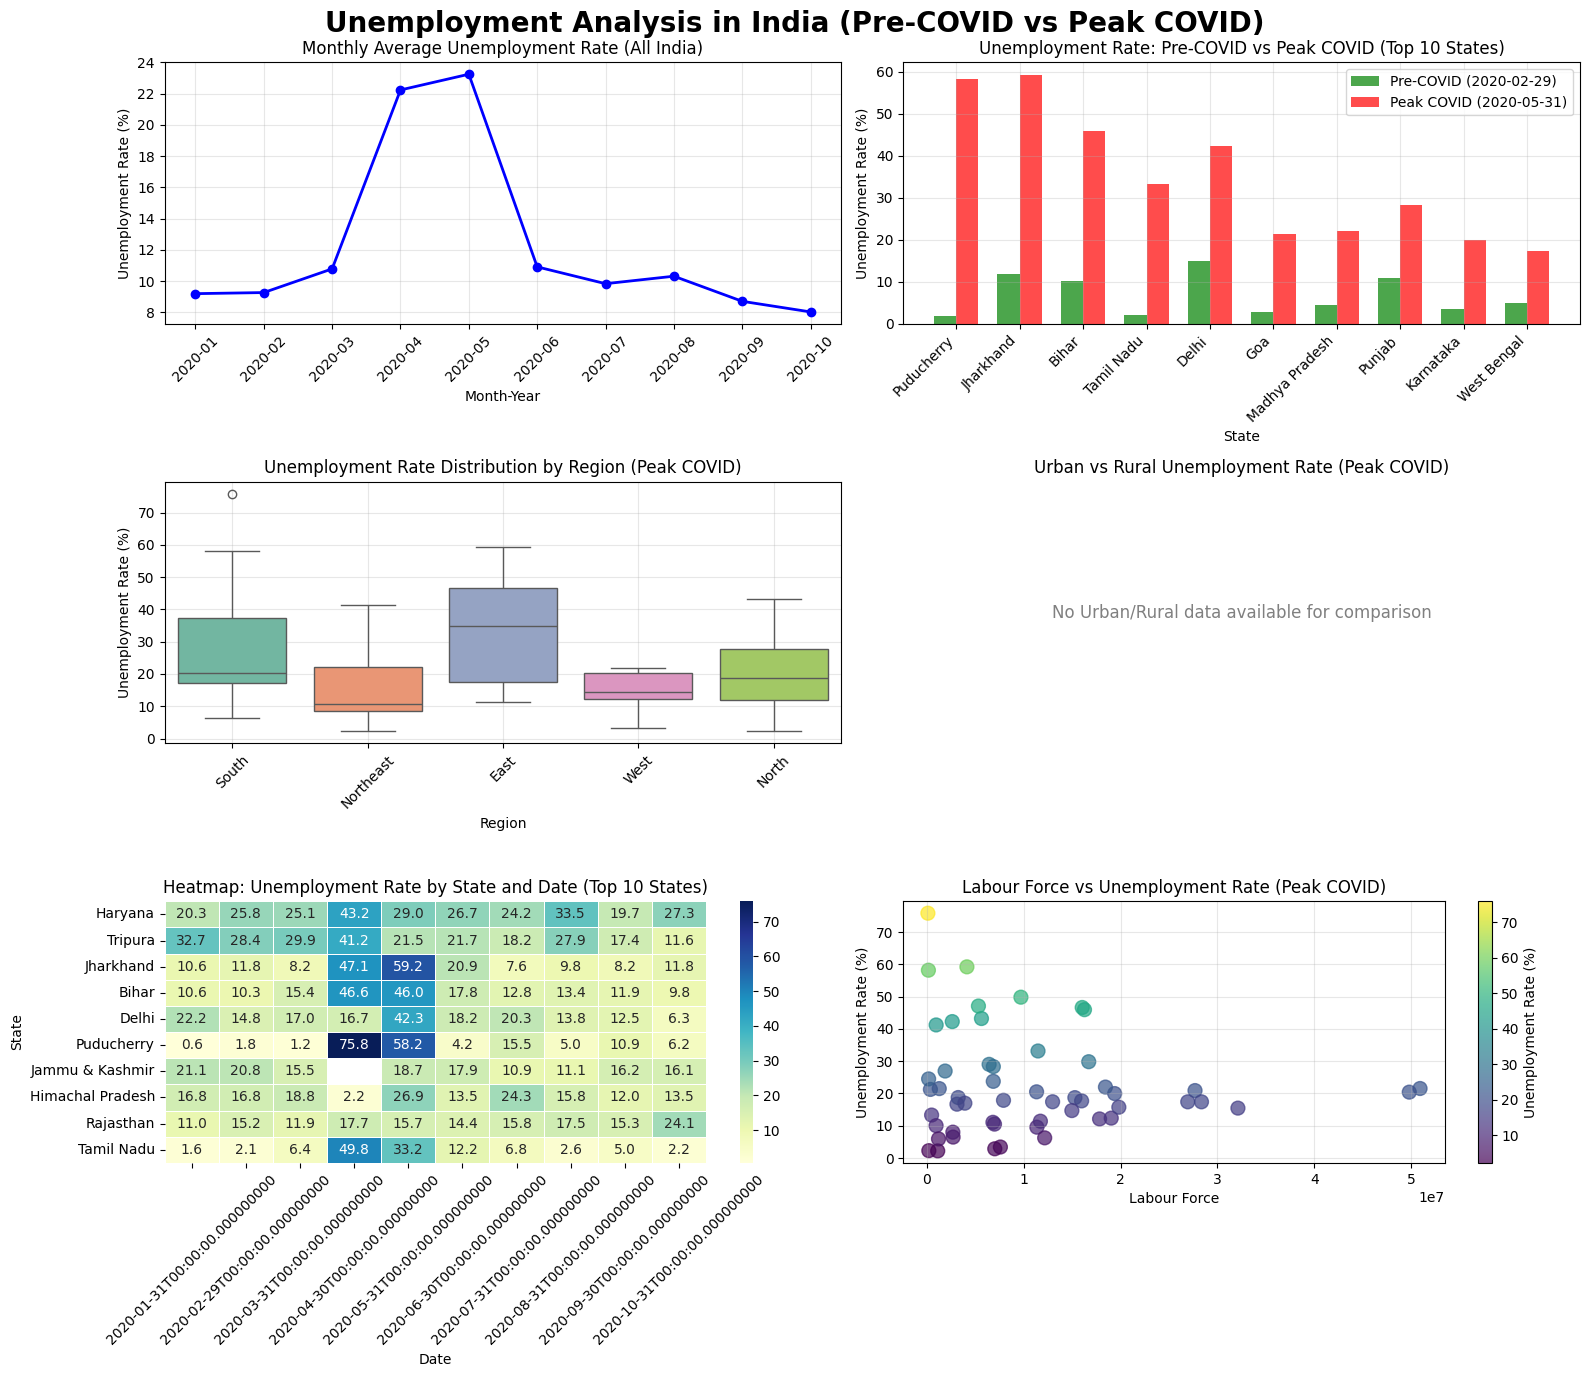


=== Summary Statistics and Key Insights ===

Overall Average Unemployment Rate: 12.24%
Maximum Unemployment Rate: 75.85%
Minimum Unemployment Rate: 0.50%

--- Regional Statistics (Peak COVID Period) ---
            mean    std    min    max
Region                               
East       33.61  18.03  11.41  59.23
North      20.01  12.56   2.20  43.22
Northeast  15.76  12.71   2.28  41.23
South      30.05  20.81   6.25  75.85
West       15.00   5.86   3.41  21.98

--- State-wise Statistics (Peak COVID Period) ---

Top 5 States by Average Unemployment Rate (Peak COVID):
             mean  count
State                   
Puducherry  67.02      2
Jharkhand   53.16      2
Bihar       46.30      2
Tamil Nadu  41.50      2
Haryana     36.12      2

Bottom 5 States by Average Unemployment Rate (Peak COVID):
               mean  count
State                     
Telangana     10.48      2
Assam         10.30      2
Meghalaya      7.98      2
Uttarakhand    7.24      2
Chhattisgarh   6.96      

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings #necessary packages

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

plt.style.use('default')

sns.set_palette("husl")

# --- 1. DATA LOADING & COMBINATION ---

print("=== Loading and Combining Datasets ===")

df1_raw = pd.read_csv('/content/drive/My Drive/OIBSIP/Unemployment in India.csv', header=None)

data_list = []
for index, row in df1_raw.iterrows():
    parts = str(row[0]).split(',')
    parts = [part.strip() for part in parts if part.strip()]
    if len(parts) == 7:
        data_list.append(parts)
    else:
        continue

df1 = pd.DataFrame(data_list, columns=['State', 'Date', 'Frequency', 'Unemployment_Rate', 'Labour_Force', 'Participation_Rate', 'Area_Type'])

df2 = pd.read_csv('/content/drive/My Drive/OIBSIP/Unemployment_Rate_upto_11_2020.csv', names=['State', 'Date', 'Frequency', 'Unemployment_Rate', 'Labour_Force', 'Participation_Rate', 'Region', 'Latitude', 'Longitude'])
#second csv file

df1['Source'] = 'File1'
df2['Source'] = 'File2'
df2['Area_Type'] = 'Combined'

common_cols = ['State', 'Date', 'Frequency', 'Unemployment_Rate', 'Labour_Force', 'Participation_Rate', 'Area_Type', 'Source']

df1_filtered = df1[common_cols]

df2_filtered = df2[['State', 'Date', 'Frequency', 'Unemployment_Rate', 'Labour_Force', 'Participation_Rate', 'Area_Type', 'Source', 'Region', 'Latitude', 'Longitude']]

df_combined = pd.concat([df1_filtered, df2_filtered], ignore_index=True)

print(f"Combined dataset shape: {df_combined.shape}")
print("\nFirst few rows of combined data:")
print(df_combined.head())

# --- 2. DATA CLEANING & PREPROCESSING ---

print("\n=== Data Cleaning & Preprocessing ===")

df_combined['Date'] = pd.to_datetime(df_combined['Date'], errors='coerce')

numeric_cols = ['Unemployment_Rate', 'Labour_Force', 'Participation_Rate']
for col in numeric_cols:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

print(f"\nMissing values before cleaning:\n{df_combined.isnull().sum()}")

df_cleaned = df_combined.dropna(subset=['State', 'Date', 'Unemployment_Rate']).copy()

df_cleaned['Area_Type'] = df_cleaned['Area_Type'].fillna('Combined')

df_cleaned['Region'] = df_cleaned['Region'].fillna('Unknown')

df_cleaned['Frequency'] = df_cleaned['Frequency'].str.strip().str.upper()

print(f"\nMissing values after cleaning:\n{df_cleaned.isnull().sum()}")
print(f"\nCleaned dataset shape: {df_cleaned.shape}")

# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---

print("\n=== Exploratory Data Analysis (EDA) ===")

print("\n--- Summary Statistics ---")
print(df_cleaned.describe(include='all'))

print(f"\nUnique States: {df_cleaned['State'].nunique()}")
print(f"Unique Regions: {df_cleaned['Region'].nunique()}")
print(f"Unique Area Types: {df_cleaned['Area_Type'].nunique()}")
print(f"Data range: {df_cleaned['Date'].min()} to {df_cleaned['Date'].max()}")

duplicates = df_cleaned.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# --- 4. COVID-19 IMPACT ANALYSIS ---

print("\n=== COVID-19 Impact Analysis ===")

pre_covid_start = '2020-01-01'
pre_covid_end = '2020-02-29'
peak_covid_start = '2020-04-01'
peak_covid_end = '2020-05-31'

df_pre_covid = df_cleaned[(df_cleaned['Date'] >= pre_covid_start) & (df_cleaned['Date'] <= pre_covid_end)]
df_peak_covid = df_cleaned[(df_cleaned['Date'] >= peak_covid_start) & (df_cleaned['Date'] <= peak_covid_end)]

print(f"\nPre-COVID data points: {len(df_pre_covid)}")
print(f"Peak COVID data points: {len(df_peak_covid)}")

avg_pre_covid = df_pre_covid['Unemployment_Rate'].mean()
avg_peak_covid = df_peak_covid['Unemployment_Rate'].mean()

print(f"\nAverage Unemployment Rate (Pre-COVID): {avg_pre_covid:.2f}%")
print(f"Average Unemployment Rate (Peak COVID): {avg_peak_covid:.2f}%")
print(f"Increase during COVID: {avg_peak_covid - avg_pre_covid:.2f}%")

state_comparison_data = df_cleaned[
    ((df_cleaned['Date'] >= pre_covid_start) & (df_cleaned['Date'] <= pre_covid_end)) |
    ((df_cleaned['Date'] >= peak_covid_start) & (df_cleaned['Date'] <= peak_covid_end))
]

state_comparison_grouped = state_comparison_data.groupby(['State', 'Date'])['Unemployment_Rate'].mean().reset_index()

state_comparison_pivot = state_comparison_grouped.pivot(index='State', columns='Date', values='Unemployment_Rate')

pre_covid_dates_available = state_comparison_pivot.columns[state_comparison_pivot.columns <= pd.Timestamp(pre_covid_end)]
peak_covid_dates_available = state_comparison_pivot.columns[state_comparison_pivot.columns <= pd.Timestamp(peak_covid_end)]
peak_covid_dates_available = peak_covid_dates_available[peak_covid_dates_available >= pd.Timestamp(peak_covid_start)]

if not pre_covid_dates_available.empty and not peak_covid_dates_available.empty:
    latest_pre_date = pre_covid_dates_available.max()
    latest_peak_date = peak_covid_dates_available.max()

    print(f"\nUsing latest available Pre-COVID date: {latest_pre_date}")
    print(f"Using latest available Peak COVID date: {latest_peak_date}")

    pre_covid_rates_for_calc = state_comparison_pivot.get(latest_pre_date, pd.Series(dtype='float64'))
    peak_covid_rates_for_calc = state_comparison_pivot.get(latest_peak_date, pd.Series(dtype='float64'))

    comparison_df = pd.DataFrame({
        latest_pre_date: pre_covid_rates_for_calc,
        latest_peak_date: peak_covid_rates_for_calc
    })

    comparison_df['Change'] = comparison_df[latest_peak_date] - comparison_df[latest_pre_date]

    state_comparison_sorted = comparison_df.sort_values('Change', ascending=False)

    print(f"\nTop 5 States with Highest Increase in Unemployment Rate:")
    print(state_comparison_sorted[['Change']].head(5))

    # --- 5. VISUALIZATION ---

    print("\n=== Data Visualization ===")

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Unemployment Analysis in India (Pre-COVID vs Peak COVID)', fontsize=20, fontweight='bold')

    ax1 = axes[0, 0]
    df_monthly = df_cleaned.copy()
    df_monthly['Month_Year'] = df_monthly['Date'].dt.to_period('M')
    monthly_avg = df_monthly.groupby('Month_Year')['Unemployment_Rate'].mean().reset_index()
    ax1.plot(monthly_avg['Month_Year'].astype(str), monthly_avg['Unemployment_Rate'], marker='o', linewidth=2, color='blue')
    ax1.set_title('Monthly Average Unemployment Rate (All India)')
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Unemployment Rate (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    top_states = state_comparison_sorted.head(10).index
    pre_covid_rates_plot = state_comparison_sorted.loc[top_states, latest_pre_date]
    peak_covid_rates_plot = state_comparison_sorted.loc[top_states, latest_peak_date]
    x = np.arange(len(top_states))
    width = 0.35

    if not pre_covid_rates_plot.empty and not peak_covid_rates_plot.empty:
        rects1 = ax2.bar(x - width/2, pre_covid_rates_plot, width, label=f'Pre-COVID ({latest_pre_date.strftime("%Y-%m-%d")})', color='green', alpha=0.7)
        rects2 = ax2.bar(x + width/2, peak_covid_rates_plot, width, label=f'Peak COVID ({latest_peak_date.strftime("%Y-%m-%d")})', color='red', alpha=0.7)
    else:
        print("Warning: No data found for plotting Pre-COVID vs Peak COVID bar chart.")
        ax2.text(0.5, 0.5, 'No data available for comparison', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12, color='gray')
        ax2.set_title('Unemployment Rate: Pre-COVID vs Peak COVID (Top 10 States)')
        ax2.set_axis_off()
        ax2 = axes[0, 1]
        ax2.set_title('Unemployment Rate: Pre-COVID vs Peak COVID (Top 10 States)')
        ax2.set_xlabel('State')
        ax2.set_ylabel('Unemployment Rate (%)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(top_states, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)


    ax2.set_title('Unemployment Rate: Pre-COVID vs Peak COVID (Top 10 States)')
    ax2.set_xlabel('State')
    ax2.set_ylabel('Unemployment Rate (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(top_states, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    boxplot_data = df_cleaned[df_cleaned['Region'] != 'Unknown'].copy()
    boxplot_data['Period'] = np.where((boxplot_data['Date'] >= peak_covid_start) & (boxplot_data['Date'] <= peak_covid_end), 'Peak COVID', 'Other')
    peak_boxplot_data = boxplot_data[boxplot_data['Period'] == 'Peak COVID']

    if not peak_boxplot_data.empty:
        sns.boxplot(data=peak_boxplot_data, x='Region', y='Unemployment_Rate', ax=ax3, palette='Set2')
        ax3.set_title('Unemployment Rate Distribution by Region (Peak COVID)')
        ax3.set_xlabel('Region')
        ax3.set_ylabel('Unemployment Rate (%)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No data available for regional boxplot in Peak COVID period', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=12, color='gray')
        ax3.set_title('Unemployment Rate Distribution by Region (Peak COVID)')
        ax3.set_axis_off()

    ax4 = axes[1, 1]
    urban_rural_data = df_cleaned[df_cleaned['Area_Type'].isin(['Urban', 'Rural'])].copy()
    if not urban_rural_data.empty:
        urban_rural_agg = urban_rural_data.groupby(['Area_Type', 'Date'])['Unemployment_Rate'].mean().reset_index()
        urban_rural_agg = urban_rural_agg[urban_rural_agg['Date'].isin(pd.date_range(peak_covid_start, peak_covid_end))]

        if not urban_rural_agg.empty:
            pivot_data = urban_rural_agg.pivot(index='Date', columns='Area_Type', values='Unemployment_Rate').reset_index()

            if 'Urban' in pivot_data.columns:
                ax4.bar(pivot_data['Date'].astype(str), pivot_data['Urban'], label='Urban', color='orange', alpha=0.7, width=0.4, align='center')
            if 'Rural' in pivot_data.columns:
                ax4.bar(pivot_data['Date'].astype(str), pivot_data['Rural'], label='Rural', color='brown', alpha=0.7, width=0.4, align='edge')
            ax4.set_title('Urban vs Rural Unemployment Rate (Peak COVID)')
            ax4.set_xlabel('Date')
            ax4.set_ylabel('Unemployment Rate (%)')
            ax4.legend()
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No Urban/Rural data available for Peak COVID period', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, fontsize=12, color='gray')
            ax4.set_title('Urban vs Rural Unemployment Rate (Peak COVID)')
            ax4.set_axis_off()
    else:
        ax4.text(0.5, 0.5, 'No Urban/Rural data available for comparison', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, fontsize=12, color='gray')
        ax4.set_title('Urban vs Rural Unemployment Rate (Peak COVID)')
        ax4.set_axis_off()

    ax5 = axes[2, 0]
    heatmap_data = df_cleaned.copy()
    pivot_heatmap = heatmap_data.pivot_table(index='State', columns='Date', values='Unemployment_Rate', aggfunc='mean')

    top_states_heatmap = pivot_heatmap.mean(axis=1).sort_values(ascending=False).head(10).index
    pivot_heatmap_top = pivot_heatmap.loc[top_states_heatmap]

    sns.heatmap(pivot_heatmap_top, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5, ax=ax5)
    ax5.set_title('Heatmap: Unemployment Rate by State and Date (Top 10 States)')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('State')
    ax5.tick_params(axis='x', rotation=45)

    ax6 = axes[2, 1]
    peak_scatter_data = df_cleaned[(df_cleaned['Date'] >= peak_covid_start) & (df_cleaned['Date'] <= peak_covid_end)].copy()
    if not peak_scatter_data.empty:
        scatter = ax6.scatter(peak_scatter_data['Labour_Force'], peak_scatter_data['Unemployment_Rate'],
                              c=peak_scatter_data['Unemployment_Rate'], cmap='viridis', alpha=0.7, s=100)
        ax6.set_title('Labour Force vs Unemployment Rate (Peak COVID)')
        ax6.set_xlabel('Labour Force')
        ax6.set_ylabel('Unemployment Rate (%)')
        plt.colorbar(scatter, ax=ax6, label='Unemployment Rate (%)')
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'No data available for scatter plot', horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes, fontsize=12, color='gray')
        ax6.set_title('Labour Force vs Unemployment Rate (Peak COVID)')
        ax6.set_axis_off()


    plt.tight_layout()
    plt.show()

    # --- 6. SUMMARY STATISTICS AND INSIGHTS ---

    print("\n=== Summary Statistics and Key Insights ===")

    print(f"\nOverall Average Unemployment Rate: {df_cleaned['Unemployment_Rate'].mean():.2f}%")
    print(f"Maximum Unemployment Rate: {df_cleaned['Unemployment_Rate'].max():.2f}%")
    print(f"Minimum Unemployment Rate: {df_cleaned['Unemployment_Rate'].min():.2f}%")

    print(f"\n--- Regional Statistics (Peak COVID Period) ---")
    region_stats = df_cleaned[(df_cleaned['Date'] >= peak_covid_start) & (df_cleaned['Date'] <= peak_covid_end)].groupby('Region')['Unemployment_Rate'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(region_stats)

    print(f"\n--- State-wise Statistics (Peak COVID Period) ---")
    state_stats = df_cleaned[(df_cleaned['Date'] >= peak_covid_start) & (df_cleaned['Date'] <= peak_covid_end)].groupby('State')['Unemployment_Rate'].agg(['mean', 'count']).round(2)
    state_stats_sorted = state_stats.sort_values('mean', ascending=False)

    print("\nTop 5 States by Average Unemployment Rate (Peak COVID):")
    print(state_stats_sorted.head(5))

    print("\nBottom 5 States by Average Unemployment Rate (Peak COVID):")
    print(state_stats_sorted.tail(5))

    print("\n" + "="*80)
    print("Analysis Complete! The code has loaded, cleaned, analyzed, and visualized the unemployment data.")
    print("Key findings: A significant increase in unemployment was observed during the peak of the COVID-19 pandemic.")
    print("="*80)

else:
    print("Error: Could not find data for the specified Pre-COVID or Peak COVID periods to calculate changes.")
    print("Available Pre-COVID dates:", pre_covid_dates_available.tolist() if not pre_covid_dates_available.empty else "None")
    print("Available Peak COVID dates:", peak_covid_dates_available.tolist() if not peak_covid_dates_available.empty else "None")
